In [ ]:
!pip install astroquery

In [2]:
import matplotlib.pyplot as plt
from astroquery.skyview import SkyView

In [5]:
# Getting Data of Andromeda (M31) Galaxy
hdu = SkyView.get_images("M31", "SDSSg")[0][0]

In [23]:
M31_header = hdu.header

In [10]:
# Getting the pixel data from hdu
M31_pixels = hdu.data

In [11]:
type(M31_pixels)

numpy.ndarray

In [12]:
M31_pixels.shape

(300, 300)

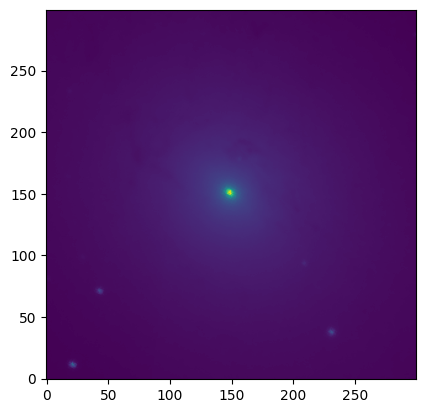

In [16]:
# Visualizing the image
plt.imshow(M31_pixels, origin='lower')
plt.show()

In [17]:
import astropy.units as u

In [18]:
hdu1 = SkyView.get_images("M31", "DSS2 Blue", pixels=600, radius=150*u.arcmin)[0][0]

In [ ]:
M31_pixels_DSS2_Blue = hdu1.data
plt.imshow(M31_pixels_DSS2_Blue, origin="lower", cmap='gray')
plt.show()

<h1>Creating our own FITS File

In [22]:
# Importing the lib.
from astropy.io import fits

In [34]:
# Create HDUList() to store different HDUs
hdu_list = fits.HDUList()

# Create PrimaryHDU()
hdu_Prime = fits.PrimaryHDU()

# Add Pixel Data
hdu_Prime.data = M31_pixels

# Add Meta Data
hdu_Prime.header = M31_header

# Append PrimaryHDU to HDUList
hdu_list.append(hdu_Prime)

# Generate FITS Data
hdu_list.writeto("FITS_file_trial.fits")

In [35]:
# Opening the FITS File
my_fits = fits.open('/content/FITS_file_trial.fits')
my_fits

In [39]:
var = my_fits[0].data

In [40]:
var.shape

(300, 300)

In [41]:
type(var)

numpy.ndarray

<h1>Pixel Scaling</h1>


In [42]:
import numpy as np

In [46]:
# Pixel value at the center of the M31 pic
M31_pixels[150, 150]

148.5

In [45]:
print("Summary statistics of the M31 Pixels:\n")
print(f'Minimum = {np.min(M31_pixels)}')
print(f'Maximum = {np.max(M31_pixels)}')
print(f'Average = {np.mean(M31_pixels)}')
print(f'Standard Deviation = {np.std(M31_pixels)}')

Summary statistics of the M31 Pixels:

Minimum = 5.359375
Maximum = 178.0
Average = 13.329444885253906
Standard Deviation = 6.3922271728515625


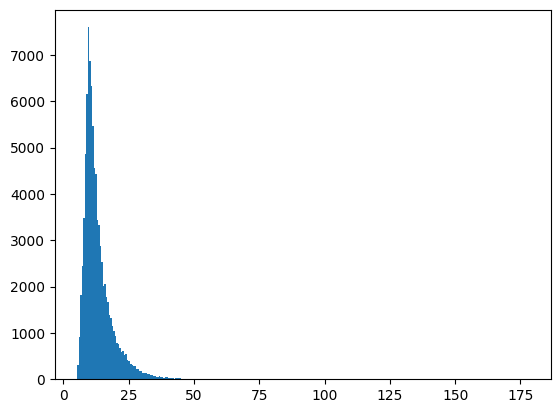

In [79]:
# Histogram Distribution
plt.hist(M31_pixels.flat, bins = 300)
plt.show()

<h1>Min-Max Scaling or Intensity Scaling
<br>
x_scaled = (x - x_min) / (x_max - x_min)

In [56]:
def plt_pix(pixel_array, title, color):
  plt.imshow(pixel_array, cmap='gray', origin='lower')
  plt.title(title, color=color)
  plt.axis('off')

In [63]:
def cmp_pix(original_array, scaled_array):
  plt.subplot(1, 2, 1)
  plt_pix(original_array, 'Original Image', 'black')
  plt.subplot(1, 2, 2)
  plt_pix(scaled_array, 'Scaled Image', 'black')
  plt.tight_layout()
  plt.show()

In [58]:
# Normalizer function
def min_max_scaling(pix_arr):
  num = pix_arr - np.min(pix_arr)
  den = np.max(pix_arr) - np.min(pix_arr)
  return num/den

In [ ]:
plt.figure(figsize=(15, 10))
min_max_arr = min_max_scaling(M31_pixels)
cmp_pix(M31_pixels, min_max_arr)

<h1>Standard Scaling (Z-Scaling)
<br>
z = (x - µ) / σ

In [65]:
def z_scale(pix_arr):
  num = pix_arr - np.mean(pix_arr)
  den = np.std(pix_arr)
  return num/den

In [ ]:
z_scaled_arr = z_scale(M31_pixels)
cmp_pix(M31_pixels, z_scaled_arr)

<h1>Log Normalization

In [68]:
def log_scaling(pix_arr):
  return np.log(pix_arr)

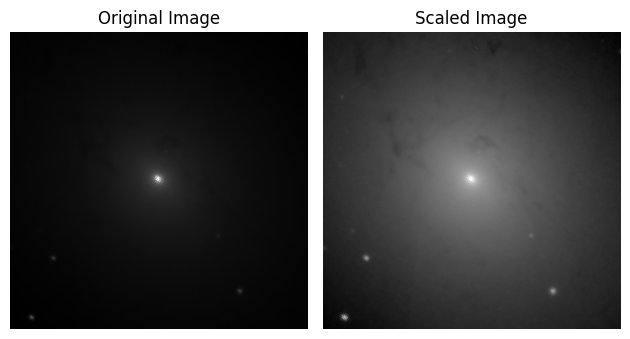

In [69]:
log_scaled_arr = log_scaling(M31_pixels)
cmp_pix(M31_pixels, log_scaled_arr)

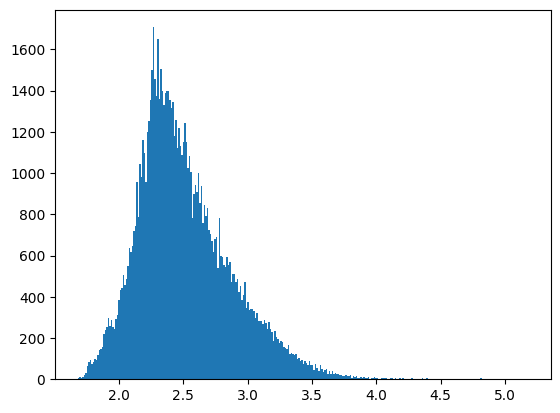

In [74]:
plt.hist(log_scaled_arr.flat, bins=300)
plt.show()

In [75]:
log_scaled_arr.shape

(300, 300)

<h1>Square root

In [76]:
def sqrt_scaling(pix_arr):
  return np.sqrt(pix_arr)

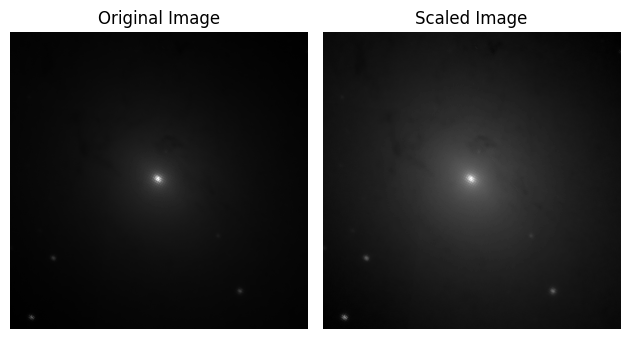

In [77]:
sqrt_scaled_arr = sqrt_scaling(M31_pixels)
cmp_pix(M31_pixels, sqrt_scaled_arr)

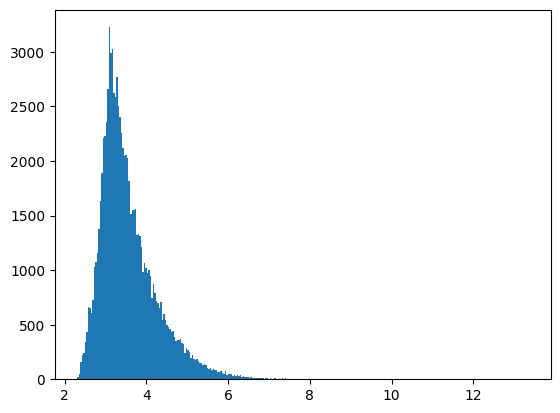

In [78]:
plt.hist(sqrt_scaled_arr.flat, bins=300)
plt.show()

<h1>ZScaleInterval

In [80]:
from astropy.visualization import ZScaleInterval

In [82]:
z = ZScaleInterval()

In [85]:
z_min, z_max = z.get_limits(log_scaled_arr)
print(f'Minimum = {z_min}; Maximum = {z_max}')

Minimum = 1.6889997720718384; Maximum = 4.447910199027213


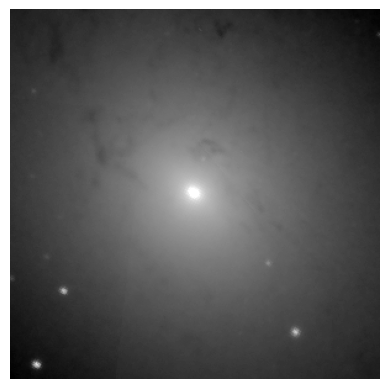

In [90]:
img = plt.imshow(log_scaled_arr, vmin=z_min, vmax=z_max, cmap='gray', origin='lower')
plt.axis('off')
plt.show()

In [100]:
img_arr = img.make_image(renderer = None, unsampled = True)[0]

In [101]:
img_arr.shape

(300, 300, 4)

**Note:-**
* Red, Green, Blue and Alpha channels make up a 4 channel image

In [102]:
import cv2

In [103]:
# Removing Alpha (Opacity) channel and converting to grayscale
gray_array = cv2.cvtColor(img_arr, cv2.COLOR_BGRA2GRAY)
gray_array.shape

(300, 300)

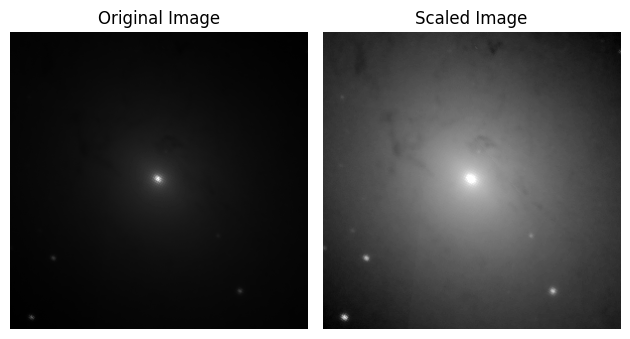

In [104]:
cmp_pix(M31_pixels, gray_array)

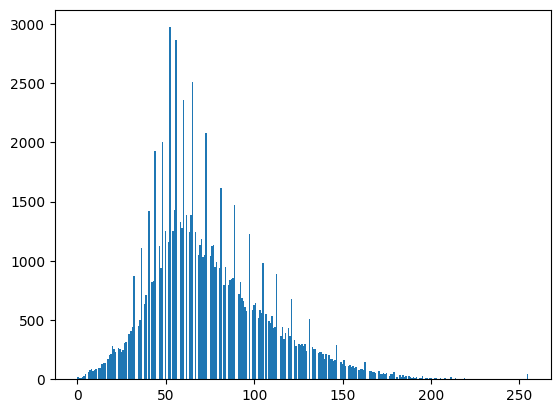

In [105]:
plt.hist(gray_array.flat, bins=300)
plt.show()

In [106]:
gray_scale_zint_arr = gray_array

<h1>Convolution and Denoising

In [108]:
from scipy.signal import convolve2d

In [112]:
# Kernel Generation
kernel = np.ones((5, 5))/25
kernel

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]])

In [113]:
gaussian_kernel = np.array([
    [1/16, 1/8, 1/16],
    [1/8, 1/4, 1/8],
    [1/16, 1/8, 1/16]
])
gaussian_kernel

array([[0.0625, 0.125 , 0.0625],
       [0.125 , 0.25  , 0.125 ],
       [0.0625, 0.125 , 0.0625]])

In [114]:
conv_img = convolve2d(M31_pixels, kernel, mode='same')

In [115]:
gaussian_conv_img = convolve2d(M31_pixels, gaussian_kernel, mode='same')

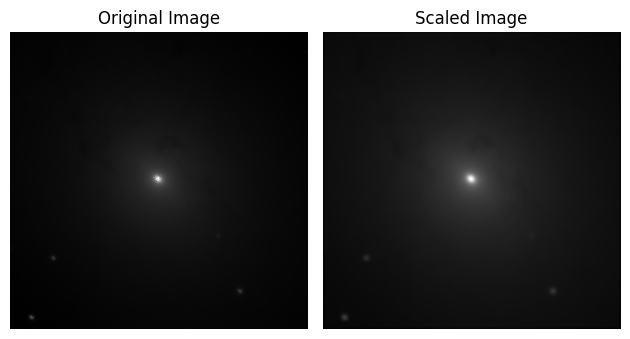

In [116]:
cmp_pix(M31_pixels, conv_img)

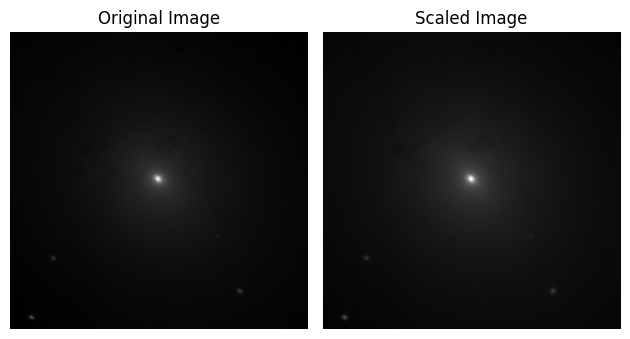

In [117]:
cmp_pix(M31_pixels, gaussian_conv_img)

In [118]:
gray_scale_conv_img = convolve2d(gray_scale_zint_arr, kernel, mode='same')

In [119]:
gray_scale_gaussian_conv_img = convolve2d(gray_scale_zint_arr, gaussian_kernel, mode='same')

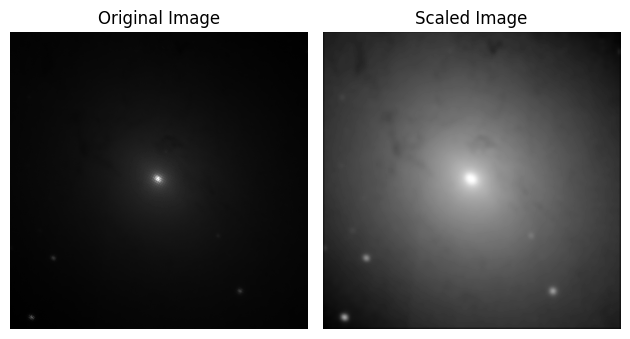

In [120]:
cmp_pix(M31_pixels, gray_scale_conv_img)

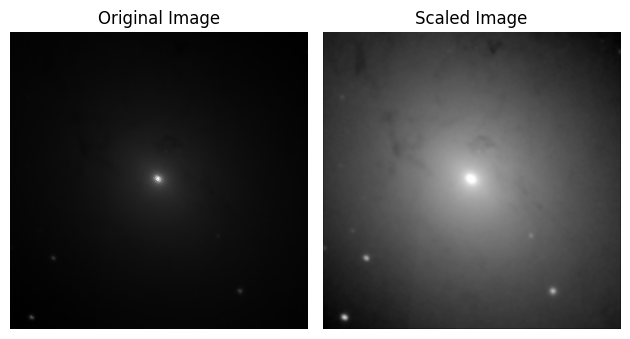

In [121]:
cmp_pix(M31_pixels, gray_scale_gaussian_conv_img)

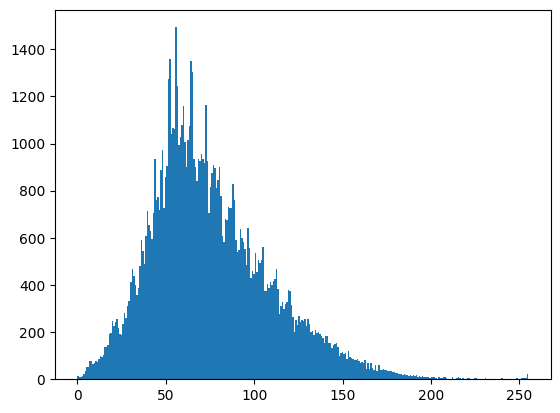

In [132]:
plt.hist(gray_scale_gaussian_conv_img.flat, bins=300)
plt.show()

<h1>Enhancing Linear Features on M31 Model

In [123]:
SPECTRAL_LIST = ['gray', 'jet', 'hot', 'prism', 'nipy_spectral']

In [126]:
from skimage.filters import meijering, sato

In [127]:
meijering_output = meijering(gray_scale_gaussian_conv_img)
sato_output = sato(gray_scale_gaussian_conv_img)

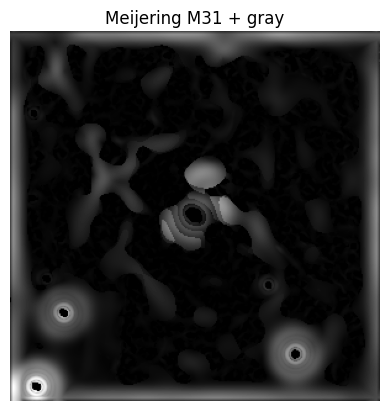

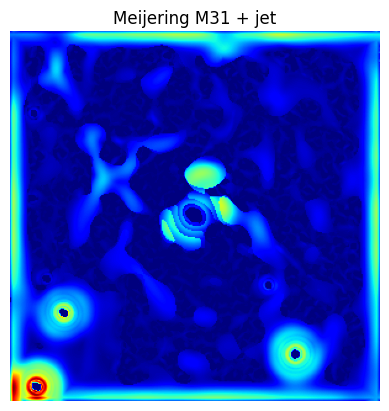

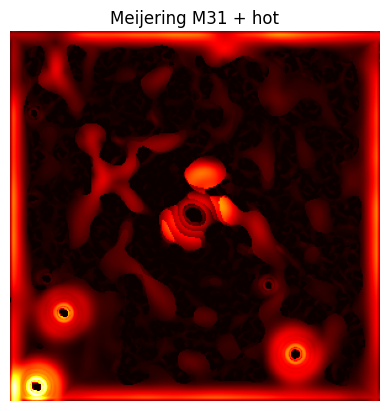

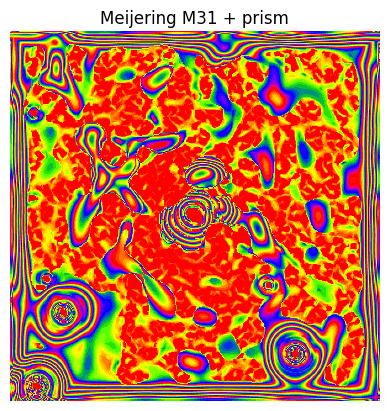

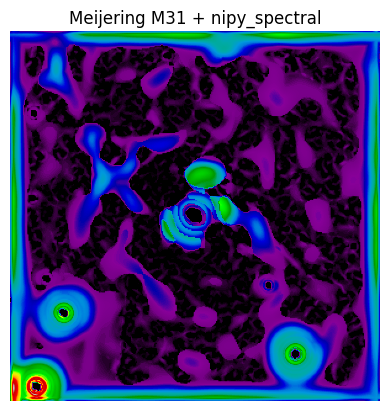

In [129]:
for colormap in SPECTRAL_LIST:
  plt.imshow(meijering_output, cmap=colormap, origin='lower')
  plt.title(f'Meijering M31 + {colormap}')
  plt.axis('off')
  plt.show()

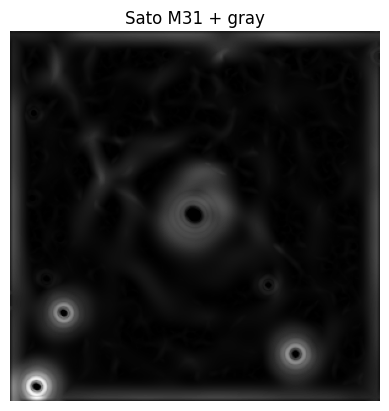

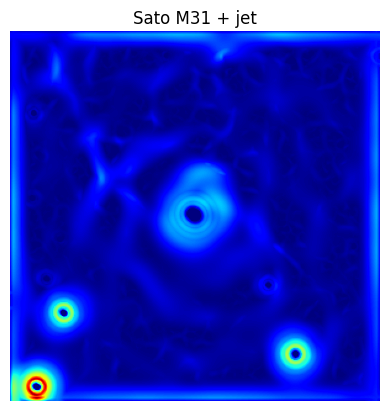

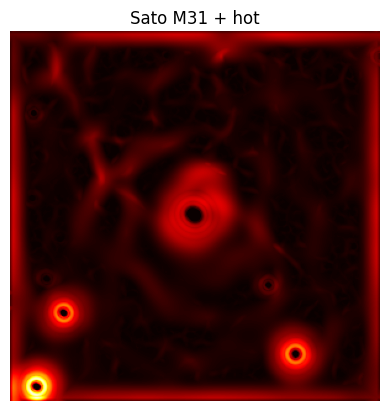

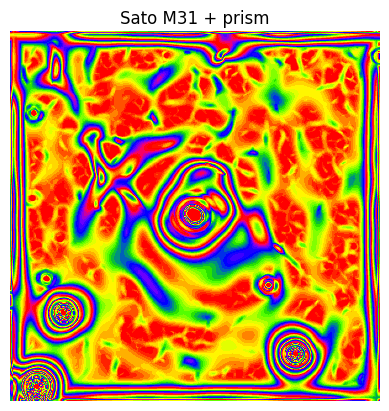

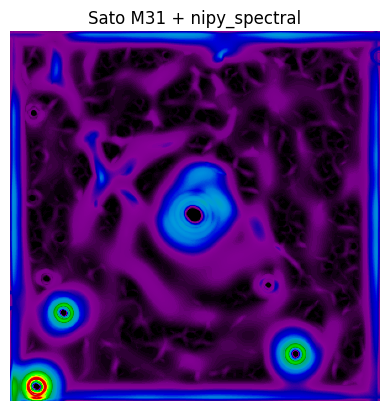

In [130]:
for colormap in SPECTRAL_LIST:
  plt.imshow(sato_output, cmap=colormap, origin='lower')
  plt.title(f'Sato M31 + {colormap}')
  plt.axis('off')
  plt.show()

<h1>Corner Foerstner

In [131]:
from skimage.feature import corner_foerstner

In [138]:
feature_output = corner_foerstner(gray_scale_gaussian_conv_img)
feature_output[1]

array([[0.4989641 , 0.21946652, 0.20260812, ..., 0.24883013, 0.65938198,
        0.71467819],
       [0.39800763, 0.23215066, 0.14497339, ..., 0.54766745, 0.90813068,
        0.66235114],
       [0.24457695, 0.17733225, 0.10416085, ..., 0.98735337, 0.55825765,
        0.25356002],
       ...,
       [0.22429728, 0.51726484, 0.96709646, ..., 0.6867379 , 0.62290977,
        0.29146722],
       [0.64334682, 0.9009524 , 0.55832027, ..., 0.49465811, 0.75665701,
        0.5648419 ],
       [0.71794373, 0.66759447, 0.2532344 , ..., 0.24465286, 0.53700323,
        0.60483135]])

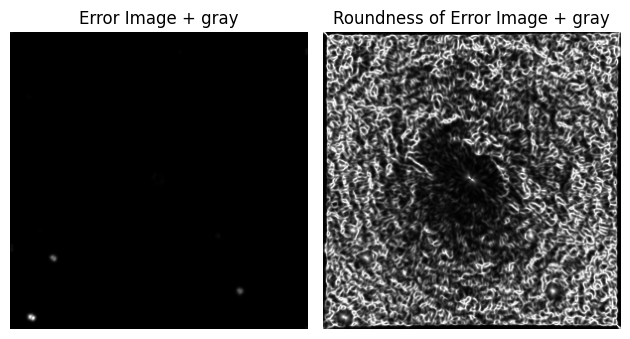

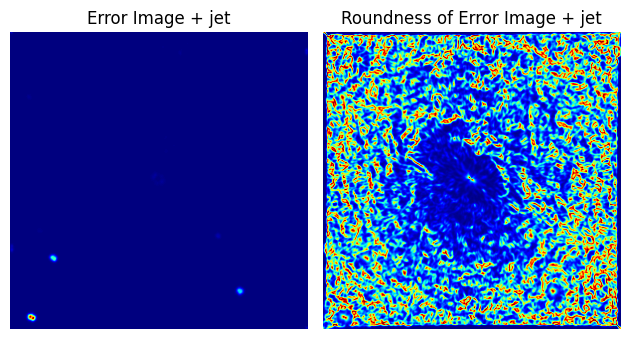

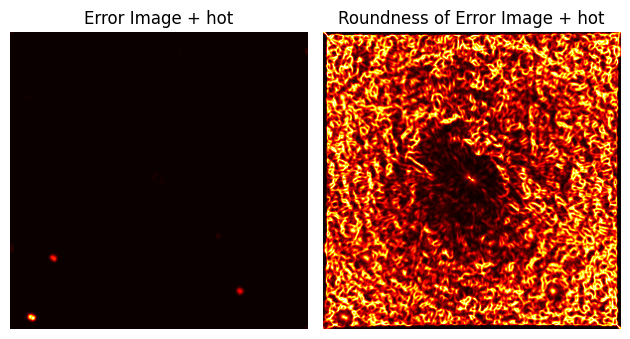

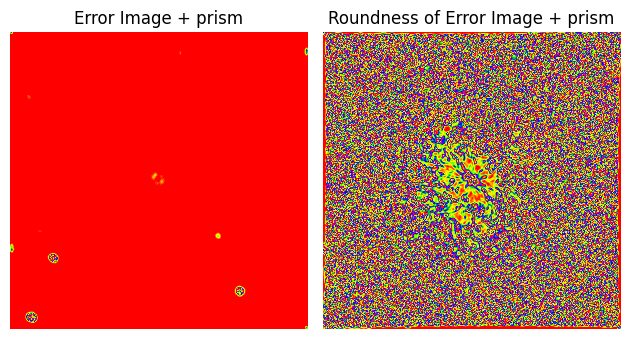

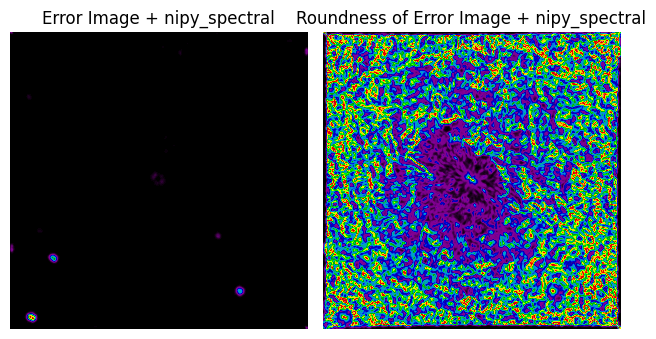

In [142]:
for colormap in SPECTRAL_LIST:
  plt.subplot(1, 2, 1)
  plt.imshow(feature_output[0], cmap=colormap, origin='lower')
  plt.title(f'Error Image + {colormap}')
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(feature_output[1], cmap=colormap, origin='lower')
  plt.title(f'Roundness of Error Image + {colormap}')
  plt.axis('off')
  plt.tight_layout()
  plt.show()

<h1>Multiscale Basic Feature

In [143]:
from skimage.feature import multiscale_basic_features

In [144]:
featured_image = multiscale_basic_features(gray_scale_gaussian_conv_img)

In [146]:
featured_image.shape

(300, 300, 24)

In [ ]:
cv2.split(featured_image)

In [154]:
len(cv2.split(featured_image))

24

In [155]:
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, p16, p17, p18, p19, p20, p21, p22, p23, p24 =  cv2.split(featured_image)

In [156]:
p1.shape

(300, 300)

In [158]:
p24.shape

(300, 300)

In [160]:
pixels = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, p16, p17, p18, p19, p20, p21, p22, p23, p24]

In [ ]:
for i, f in enumerate(pixels):
  plt.imshow(f, cmap='prism', origin='lower')
  plt.title(f'Feature {i+1}')
  plt.axis('off')
  plt.show()